In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 300
})



from Finite_volume_method_1D import *

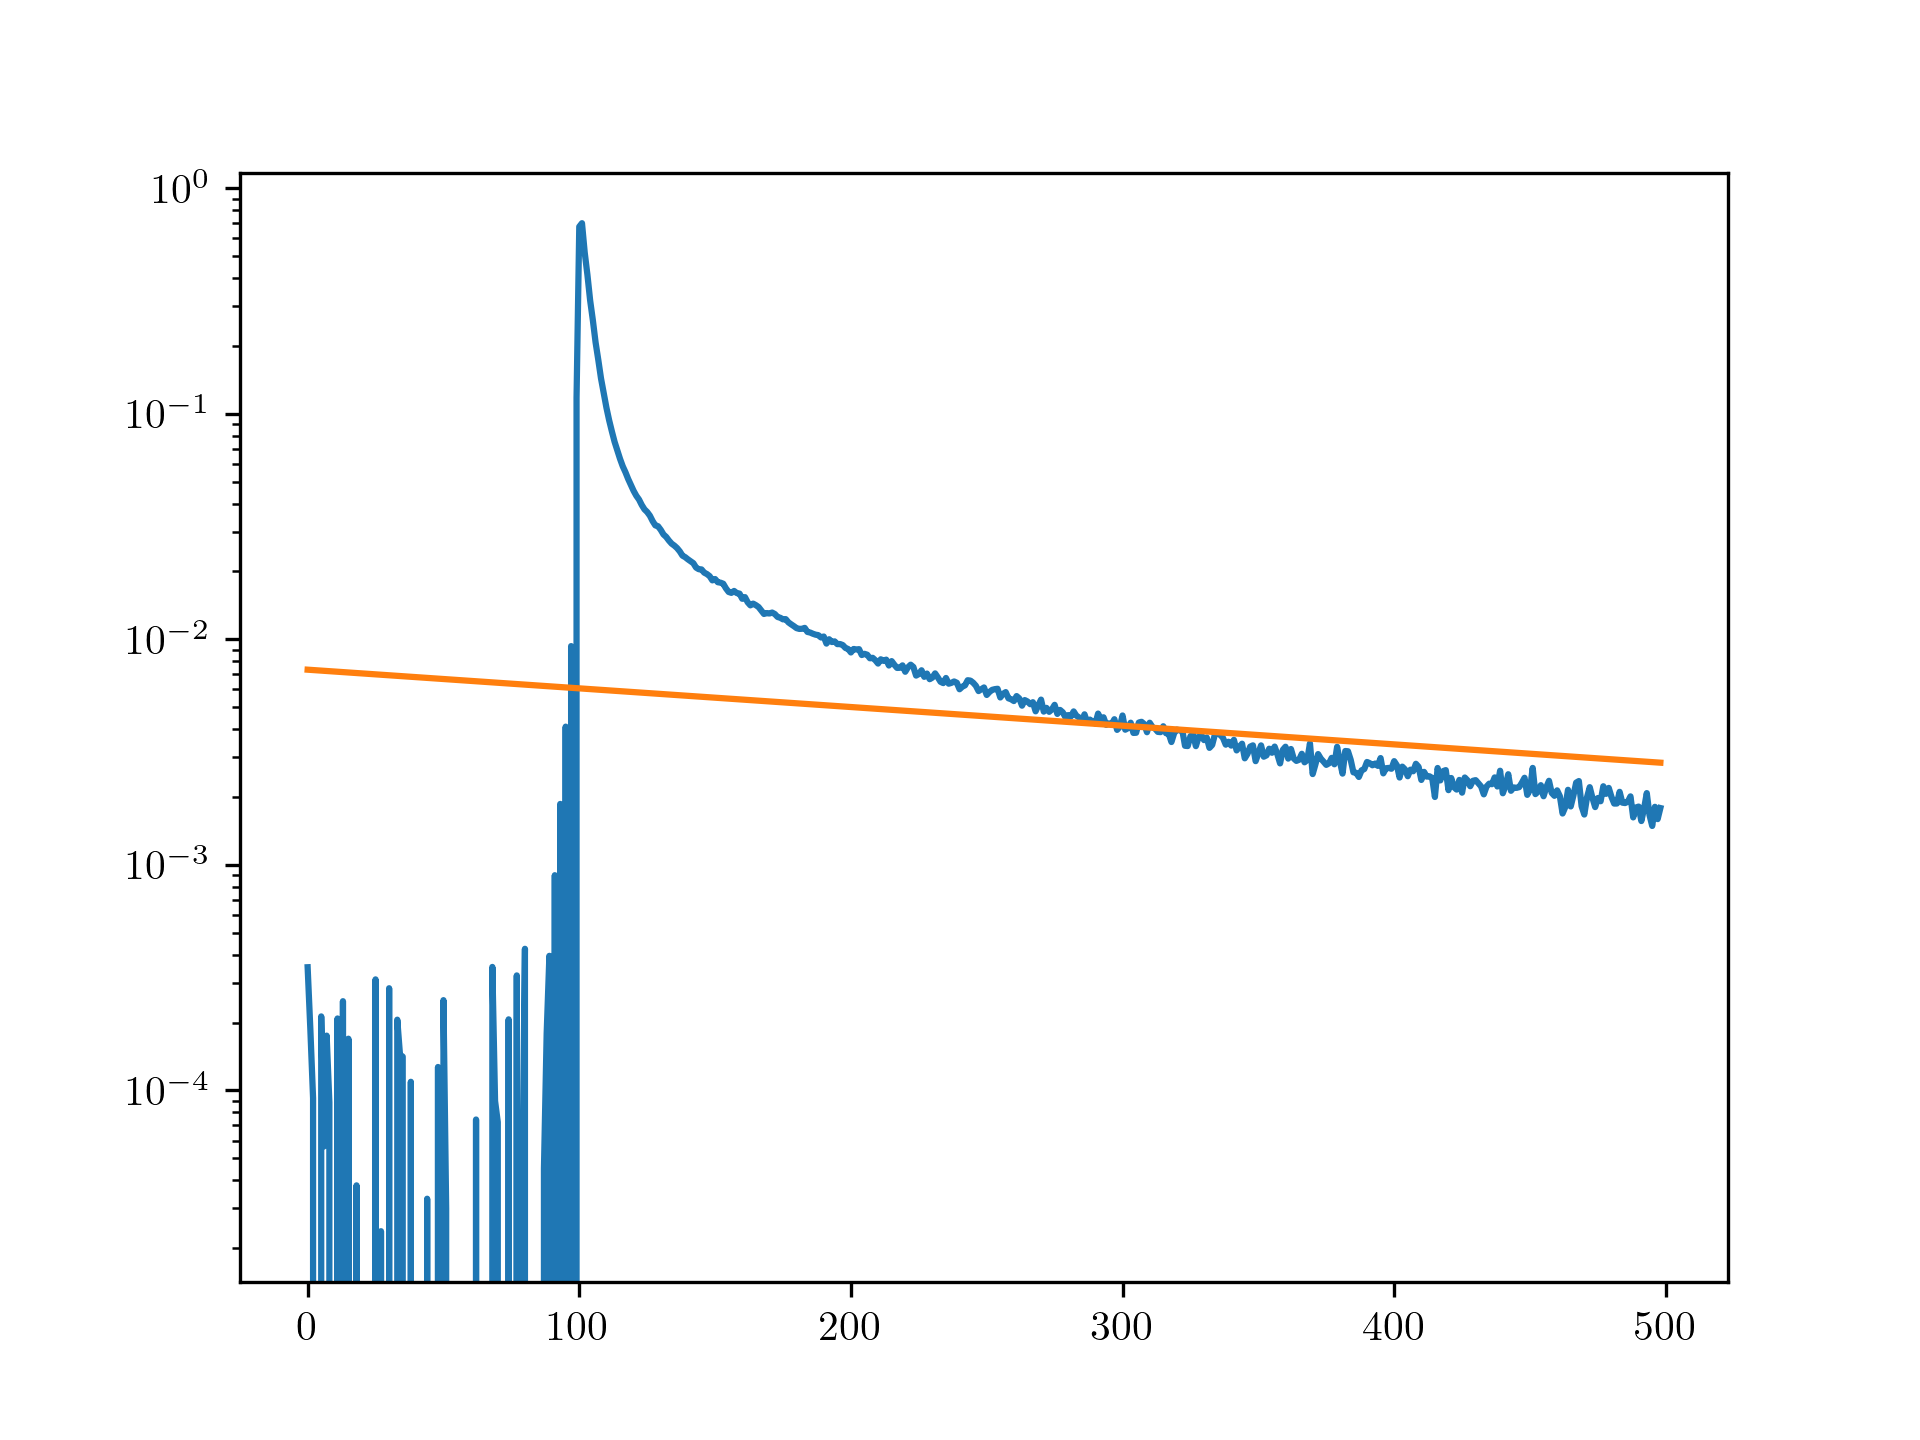

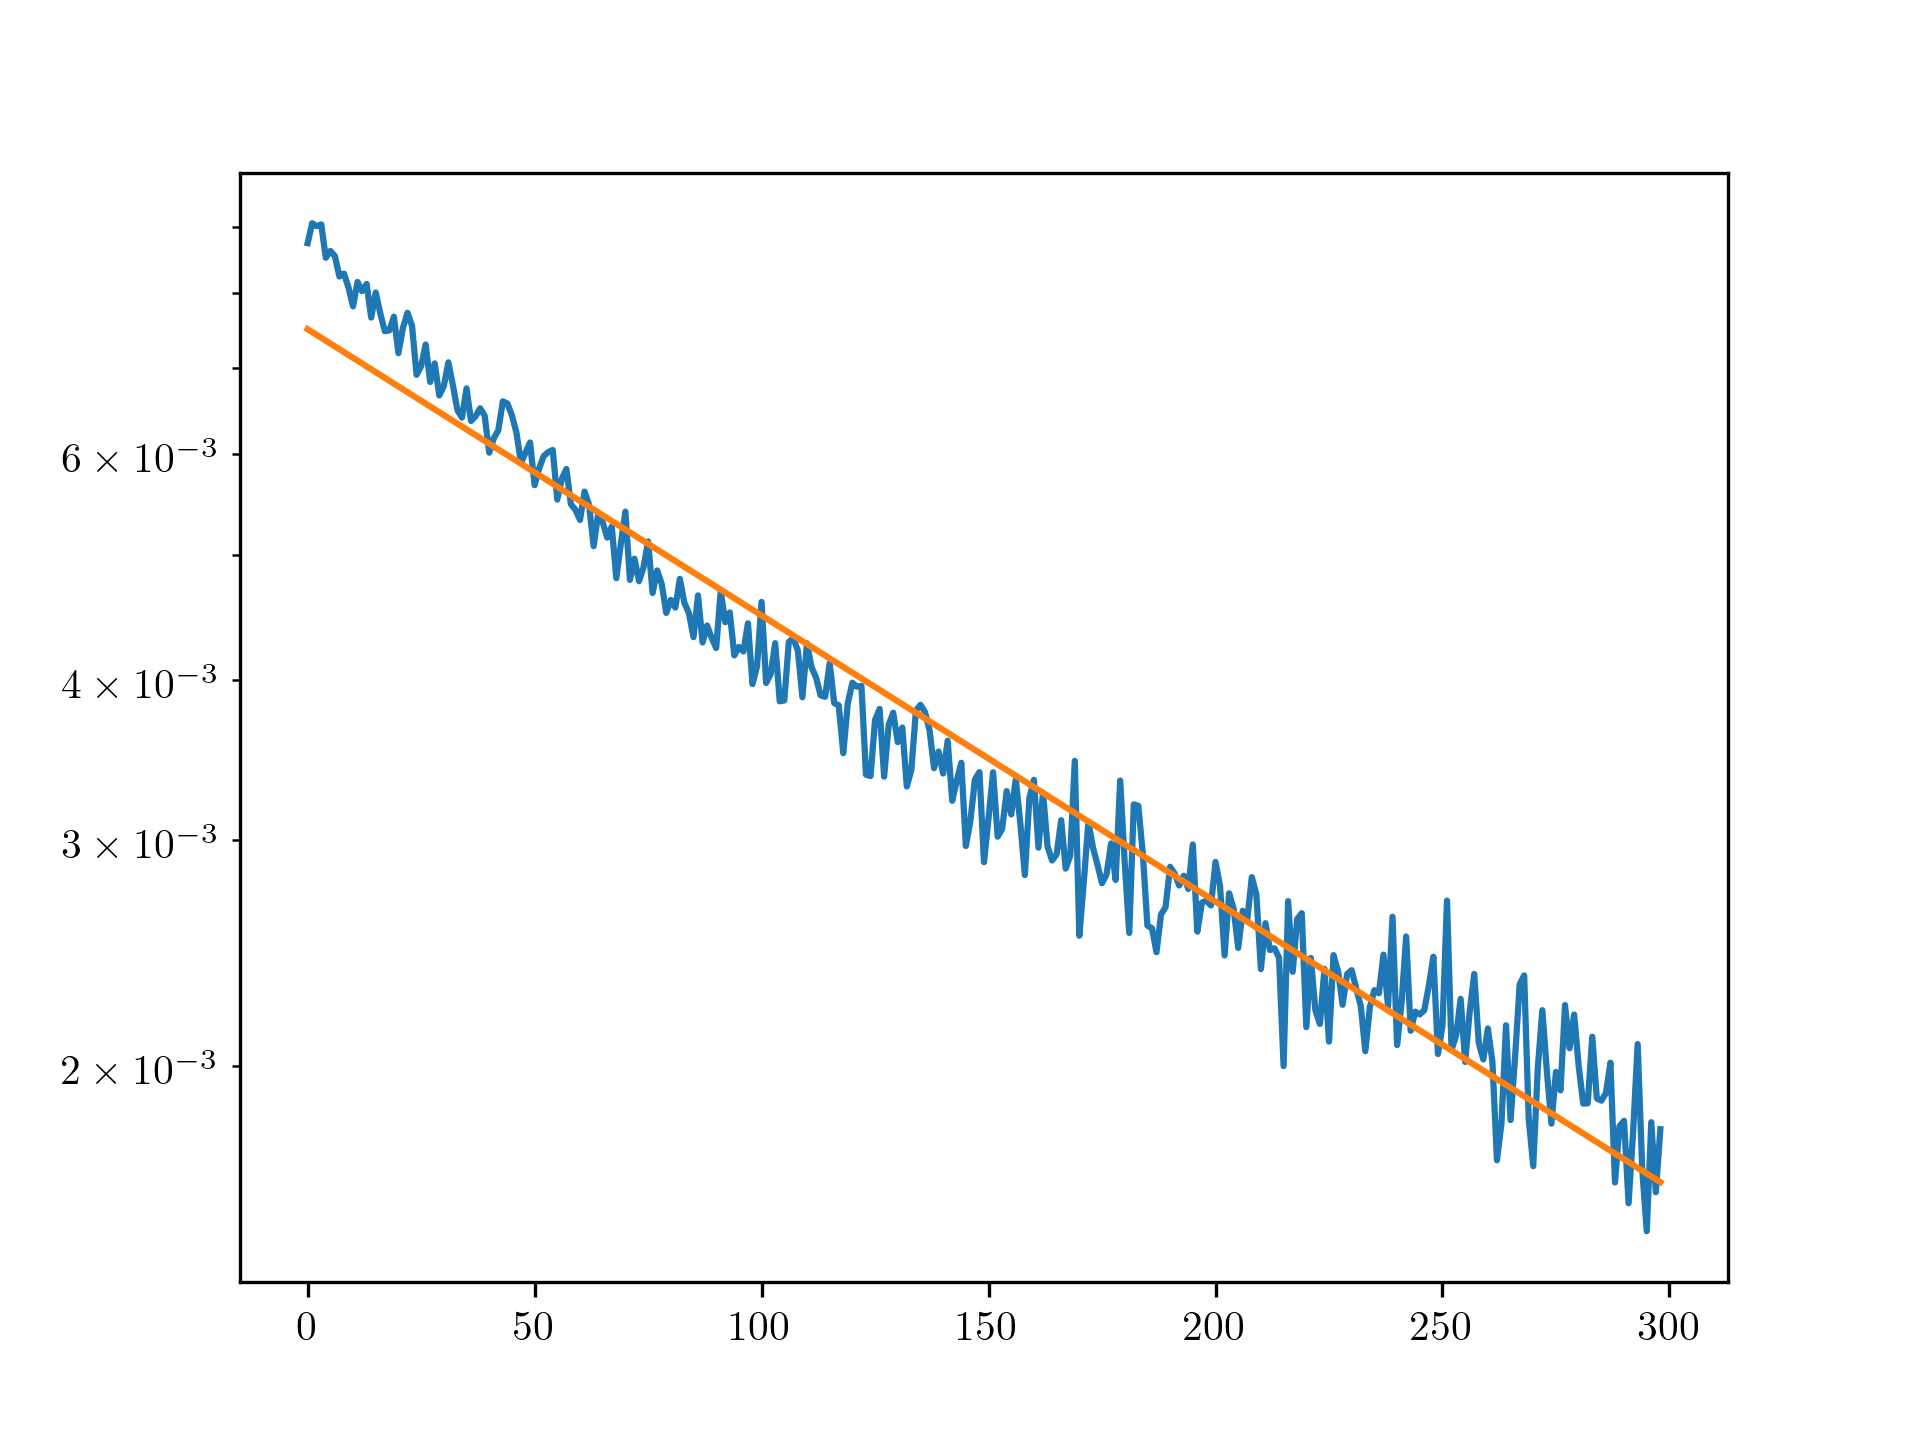

In [2]:
chippath = '../../DataKian/bTa_LT278W2chip5/'
filename = 'KID3_96dBm__TmK20_avgpulse_ampphase.csv'
length = 90
simtime = 300
tau_trickle = 0.128
dtinit=0.005
dxfrac=1/5

lambdasinnm = [402]
KIDdict = {}
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(showplots=True)
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(start=200,showplots=True)

In [3]:
Ls=[]
for lambdanm in lambdasinnm:
    print(KIDdict[lambdanm].tauqpstar,KIDdict[lambdanm].tauqpstarstd)
    print(KIDdict[lambdanm].L)
    Ls.append(KIDdict[lambdanm].L)
L=np.mean(Ls)

194.88850185176454 2.2767849027049727
0.005131139038467322


In [9]:
def prep_data(neg_offset):
    ylist = []
    for lambdanm in lambdasinnm:
        xfit = np.arange(neg_offset,neg_offset+simtime-KIDdict[lambdanm].dt/2,KIDdict[lambdanm].dt)
        indmin = np.argmax(KIDdict[lambdanm].phase)+neg_offset
        indmax = indmin + simtime
        ylist.append(KIDdict[lambdanm].phase[indmin:indmax])
    yfit = np.array(ylist).ravel()
    return xfit, yfit

def func_to_parallelize(t,params):
     SIM = KID_sim(params,dtinit,dxfrac,simtime_approx=simtime,D_const=False)
     return np.interp(t,SIM.t_axis_interp,SIM.phaseintime)

def fitfunc(t,sigma,Q0,dthetadN):
    print('sigma (um):\t',sigma)
    print('Q0 (um-1):\t',Q0)
    print('dthetadN:\t',dthetadN)
    datalist = Parallel(n_jobs=len(lambdasinnm))(delayed(func_to_parallelize)(t,KID_params(eta_pb=consts.eta_pb_max,sigma_IC=sigma,trickle_time=tau_trickle,Q0=Q0,dthetadN=dthetadN,KID=KIDdict[lambdanm],L=L)) for lambdanm in lambdasinnm)
    return np.concatenate(datalist)

def parallelize_plot(params):
     SIM = KID_sim(params,dtinit,dxfrac,simtime_approx=simtime,D_const=False)
     return SIM

def plotsim(sigma,Q0,dthetadN):
    datalist = Parallel(n_jobs=4)(delayed(parallelize_plot)(KID_params(eta_pb=consts.eta_pb_max,sigma_IC=sigma,trickle_time=tau_trickle,Q0=Q0,dthetadN=dthetadN,KID=KIDdict[lambdanm],L=L)) for lambdanm in lambdasinnm)
    plotdata = {}
    for obj,lambdanm in zip(datalist,lambdasinnm):
         plotdata[lambdanm]=obj
    return plotdata

In [10]:
xfit,yfit=prep_data(-1) #-5 means take 5 data points before the max into account for the data, we should align the maxima of the data to t=0
#popt, pcov = curve_fit(fitfunc,xfit,yfit,p0=[0.5,1.3,1],bounds=[[0.1,dtinit,0.1],[length/2,np.inf,np.inf]])
popt, pcov = curve_fit(fitfunc,xfit,yfit,p0=[0.5,1,0.5],bounds=[[0.1,0.1,0],[length/2,np.inf,np.inf]])
print('Done!')

sigma (um):	 0.5
Q0 (um-1):	 1.0
dthetadN:	 0.5
Iteration: 447	Simtime (us): 301.730448705767976
sigma (um):	 0.5000000149011612
Q0 (um-1):	 1.0
dthetadN:	 0.5
Iteration: 447	Simtime (us): 301.73044823782355
sigma (um):	 0.5
Q0 (um-1):	 1.0000000149011612
dthetadN:	 0.5
Iteration: 447	Simtime (us): 301.73043938295416
sigma (um):	 0.5
Q0 (um-1):	 1.0
dthetadN:	 0.5000000149011612
Iteration: 447	Simtime (us): 301.730448705767976
sigma (um):	 0.3411421055710385
Q0 (um-1):	 0.6751447755939658
dthetadN:	 0.3125790270052212
Iteration: 386	Simtime (us): 302.80266302736483
sigma (um):	 0.3411421204721997
Q0 (um-1):	 0.6751447755939658
dthetadN:	 0.3125790270052212
Iteration: 386	Simtime (us): 302.80266269851887
sigma (um):	 0.3411421055710385
Q0 (um-1):	 0.675144790495127
dthetadN:	 0.3125790270052212
Iteration: 386	Simtime (us): 302.80264953520395
sigma (um):	 0.3411421055710385
Q0 (um-1):	 0.6751447755939658
dthetadN:	 0.3125790419063824
Iteration: 386	Simtime (us): 302.80266302736483
sigma 

In [11]:
# Display parameters, standard deviation, and correlation coefficient
parameters = ['sigma','Q0','dthetadN']
print("Parameters:")
for name, param, std in zip(parameters,popt,np.sqrt(np.diag(pcov))):
    print(f"{name}:\t{param:.10f}\t+/-\t{std:.10f}")

print("\nCorrelation Coefficients:")
for i in range(len(popt)):
    for j in range(i+1, len(popt)):
        print(f"{parameters[i]} vs {parameters[j]}: {pcov[i,j]/np.prod(np.sqrt(pcov[i,i]*pcov[j,j])):.10f}")

Parameters:
sigma:	0.5737019754	+/-	9.2246248839
Q0:	0.1552696575	+/-	0.5068570652
dthetadN:	0.0004095228	+/-	0.0012584633

Correlation Coefficients:
sigma vs Q0: 0.9958061281
sigma vs dthetadN: -0.9975317657
Q0 vs dthetadN: -0.9996773844


In [12]:
simdata = plotsim(popt[0],popt[1],popt[2])

Iteration: 218	Simtime (us): 305.52465257099635


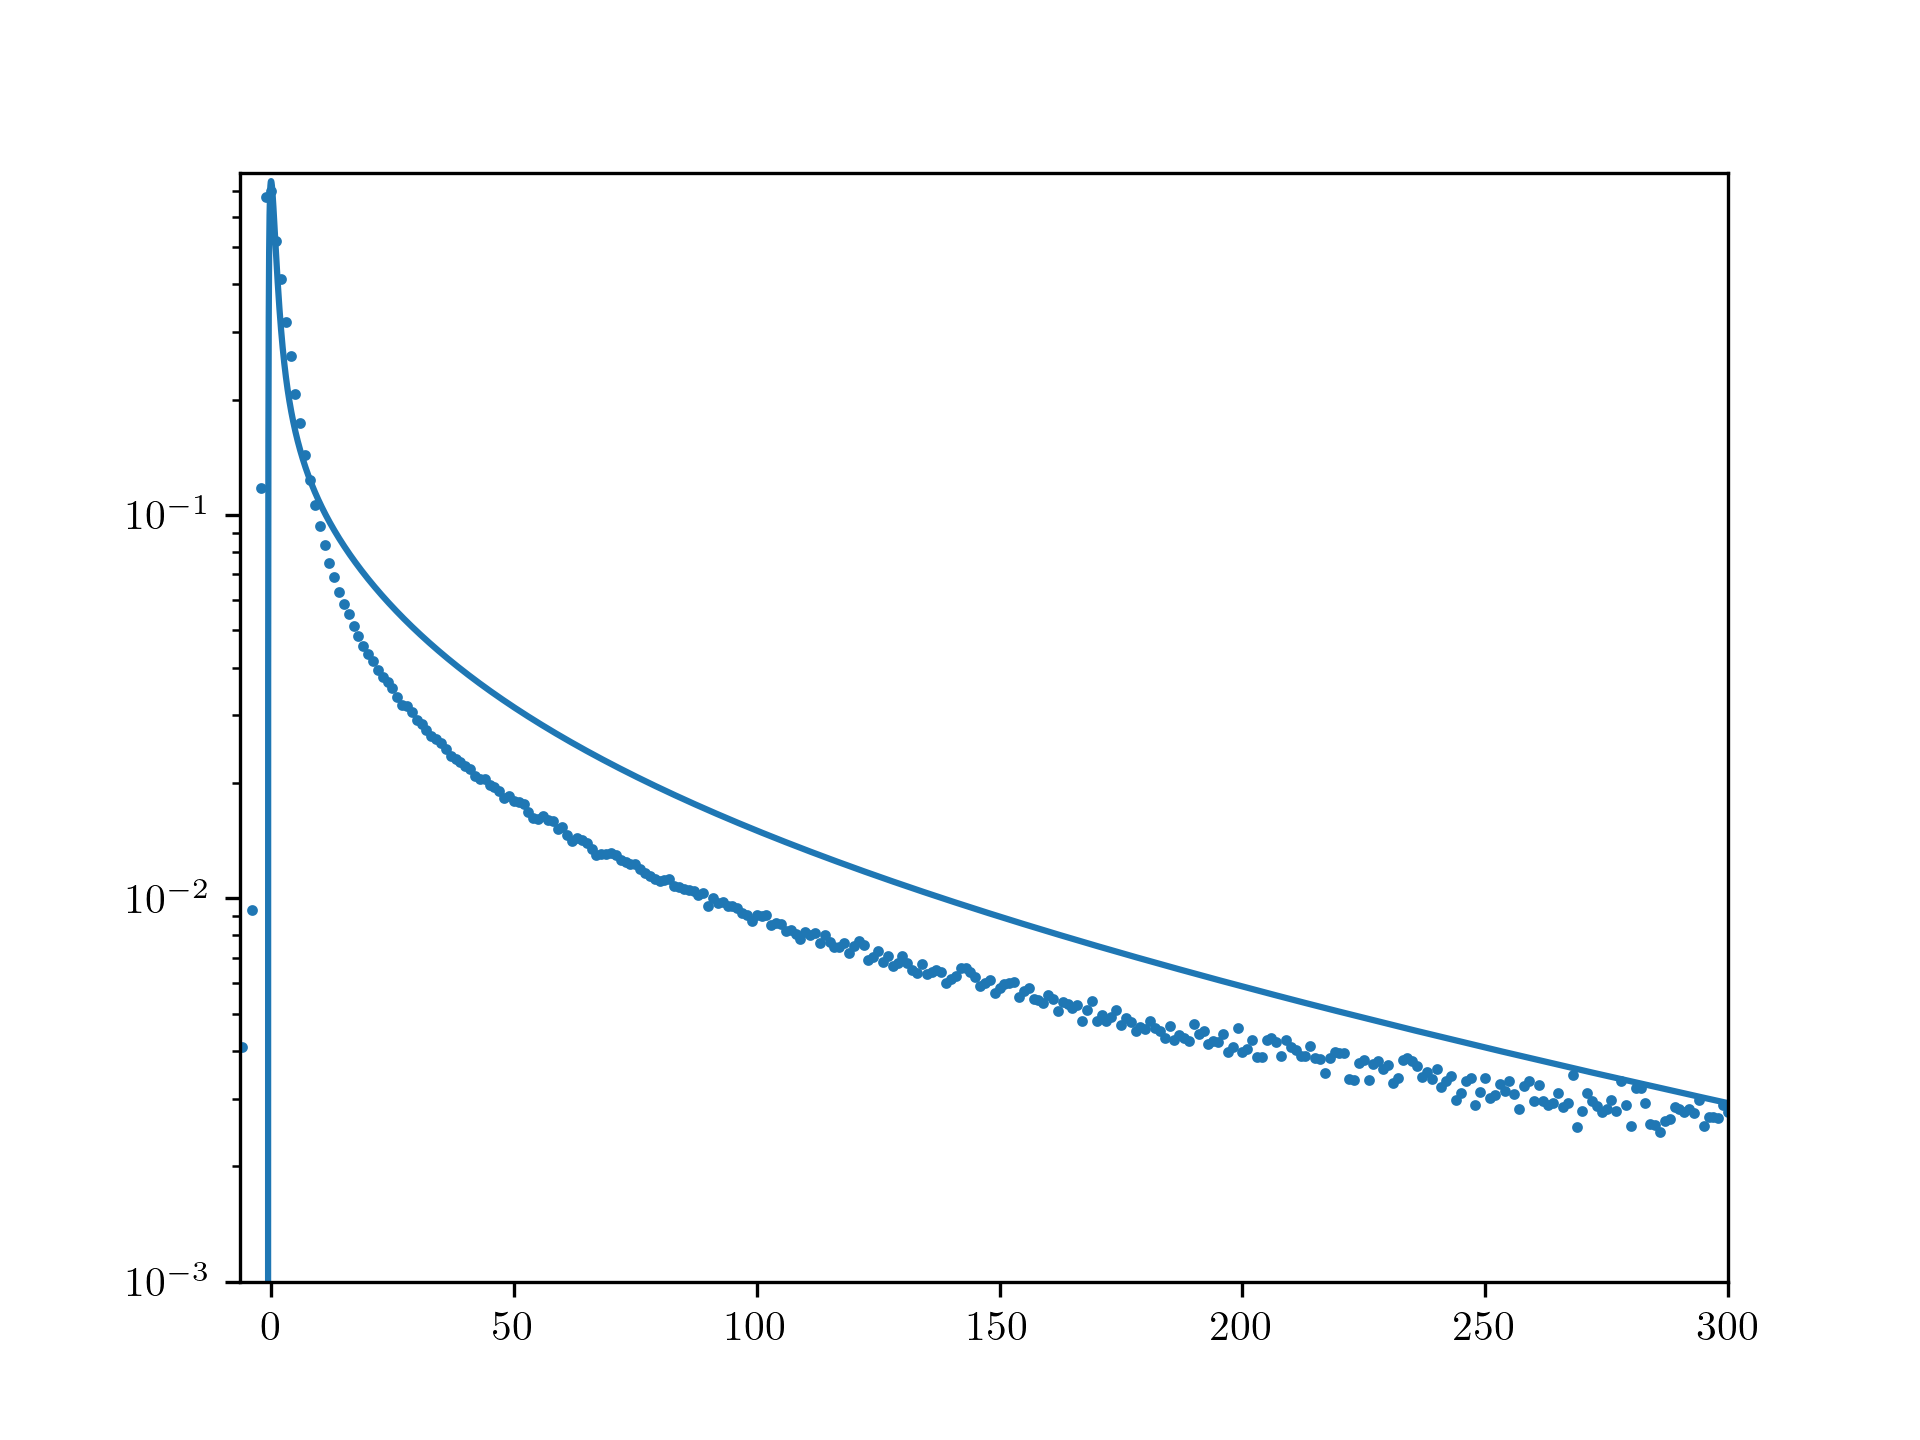

In [14]:
lambdasinnm = [402]
#lambdasinnm = [402,673,986,1545]
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.plot(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime)
    plt.scatter(t,phase,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,300)
plt.ylim(1e-3)
plt.semilogy()
plt.show()

In [ ]:
xfit,yfit,ylist=prep_data(-1) #-5 means take 5 data points before the max into account for the data
#popt, pcov = curve_fit(fitfunc,xfit,yfit,p0=[0.5,2*dtinit,1],bounds=[[0.1,dtinit,0.005],[length,10,10000]])

plt.figure()
for yfit,lambdanm in zip(ylist,lambdasinnm):
    plt.plot(xfit,yfit*lambdanm)
plt.show()